<a href="https://colab.research.google.com/github/ckkissane/deep_learning_curriculum/blob/triton-sol/solutions/3_Training_at_Scale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Write an implementation of [Adam](https://arxiv.org/abs/1412.6980) using Triton, which is "fused" in the sense that the entire update is performed by a single call to low-level GPU code.

## First write the code for the update rule that can be compiled using `@triton.jit` decorator.

In [ ]:
!pip install -U --pre triton

In [2]:
import torch
from torch import nn

import triton
import triton.language as tl

In [3]:
@triton.jit
def adam_update_kernel(
    p_ptr, 
    g_ptr, 
    m_ptr, 
    v_ptr,
    n_elements, 
    beta1,
    beta2,
    beta1_t,
    beta2_t,
    lr,
    wd,
    t,
    eps, 
    BLOCK_SIZE: tl.constexpr
):
    pid = tl.program_id(0)

    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)

    p_ptrs = p_ptr + offsets
    g_ptrs = g_ptr + offsets
    m_ptrs = m_ptr + offsets
    v_ptrs = v_ptr + offsets

    mask = offsets < n_elements

    m = tl.load(m_ptrs, mask=mask)
    g = tl.load(g_ptrs, mask=mask)
    v = tl.load(v_ptrs, mask=mask)
    p = tl.load(p_ptrs, mask=mask)

    g_wd = g + wd * p

    m_out = beta1 * m + (1.0 - beta1) * g_wd
    tl.store(m_ptrs, m_out, mask=mask)

    v_out = beta2 * v + (1.0 - beta2) * (g_wd * g_wd)
    tl.store(v_ptrs, v_out, mask=mask)

    m_hat = m_out / (1.0 - beta1_t)
    v_hat = v_out / (1.0 - beta2_t)

    p_out = p - lr * m_hat / (tl.sqrt(v_hat) + eps)
    tl.store(p_ptrs, p_out, mask=mask)

## Then write the PyTorch function that calls the compiled update rule.

In [10]:
class FusedAdam:
    def __init__(
        self,
        params,
        lr: float,
        betas, # tuple[float, float]
        eps: float,
        weight_decay: float,
    ):
        self._parameters = list(params)
        self.num_elements = sum(p.numel() for p in self._parameters)

        self._param_buffer = None
        self._grad_buffer = None
        self._init_buffers()

        self.make_params_contiguous()

        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.wd = weight_decay

        self.m = torch.zeros_like(self._param_buffer)
        self.v = torch.zeros_like(self._param_buffer)
        self.t = 0

    def _init_buffers(self):
        dtype = self._parameters[0].dtype
        device = self._parameters[0].device
        assert all(p.dtype == dtype for p in self._parameters)
        assert all(p.device == device for p in self._parameters)
        self._param_buffer = torch.zeros(self.num_elements, dtype=dtype, device=device)
        self._grad_buffer =  torch.zeros(self.num_elements, dtype=dtype, device=device)

    def make_params_contiguous(self):
        index = 0
        for p in self._parameters:
            size = p.numel()
            self._param_buffer[index:index + size] = p.data.view(-1)
            p.data = self._param_buffer[index:index + size].view(p.data.shape)
            p.grad = self._grad_buffer[index:index + size].view(p.data.shape)
            index += size
        self._param_buffer.grad = self._grad_buffer

    def zero_grad(self):
        if self._param_buffer.grad is not None:
            if self._param_buffer.grad.grad_fn is not None:
                self._param_buffer.grad.detach_()
            else:
                self._param_buffer.grad.requires_grad_(False)
            self._param_buffer.grad.zero_()

    def step(self):
        self.t += 1
        with torch.no_grad():
            grid = lambda meta: (triton.cdiv(self.num_elements, meta['BLOCK_SIZE']),)

            adam_update_kernel[grid](
                self._param_buffer, 
                self._param_buffer.grad, 
                self.m, 
                self.v,
                self.num_elements, 
                self.beta1,
                self.beta2,
                self.beta1**self.t,
                self.beta2**self.t,
                self.lr,
                self.wd,
                self.t,
                self.eps, 
                BLOCK_SIZE=1024
            )

## Benchmark your implementation and compare it to torch.optim.Adam.

First let's test correctness

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert device == torch.device('cuda')

In [12]:
def _check_equal(tensor1, tensor2):
    if torch.allclose(tensor1, tensor2, rtol=1e-3, atol=1e-5):
        print("Congrats! You've passed the test.")
    else:
        print("Your optimizer returns different results from the pytorch solution.")

def _train_with_opt(data, model, optimizer):
    for i, x in enumerate(data):
        optimizer.zero_grad()
        loss = model(x).sum()
        loss.backward()
        optimizer.step()

def test_adam(_Adam):
    test_cases = [
        dict(lr=0.1, betas=(0.8, 0.95), eps=0.001, weight_decay=0.0),
        dict(lr=0.1, betas=(0.8, 0.9), eps=0.001, weight_decay=0.05),
        dict(lr=0.2, betas=(0.9, 0.95), eps=0.01, weight_decay=0.08),
    ]
    for opt_config in test_cases:
        data = torch.randn(5, 1, 8).to(device)
    
        torch.manual_seed(42)
        model = nn.Sequential(nn.Linear(8, 8), nn.Linear(8, 8)).to(device)
        optimizer = torch.optim.Adam(model.parameters(), **opt_config)
        _train_with_opt(data, model, optimizer)
        w0_correct = model[0].weight
    
        torch.manual_seed(42)
        model = nn.Sequential(nn.Linear(8, 8), nn.Linear(8, 8)).to(device)
        optimizer = _Adam(model.parameters(), **opt_config)
        _train_with_opt(data, model, optimizer)
        w0_submitted = model[0].weight
    
        print("\nTesting configuration: ", opt_config)
        _check_equal(w0_correct, w0_submitted)
    
test_adam(FusedAdam)


Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.95), 'eps': 0.001, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.9), 'eps': 0.001, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'betas': (0.9, 0.95), 'eps': 0.01, 'weight_decay': 0.08}
Congrats! You've passed the test.


Now benchmark

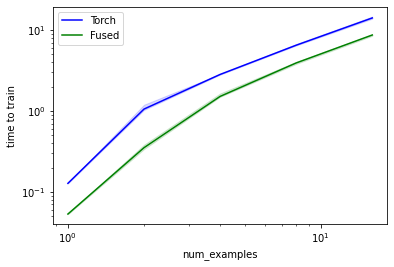

adam-optim-performance:
   num_examples      Torch     Fused
0           1.0   0.127616  0.053280
1           2.0   1.055168  0.351712
2           4.0   2.826336  1.512736
3           8.0   6.492608  3.919840
4          16.0  14.099376  8.685904


In [13]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['num_examples'],  # argument names to use as an x-axis for the plot
        x_vals=[
            2**i for i in range(5)
        ],  # different possible values for `x_name`
        x_log=True,  # x axis is logarithmic
        y_log=True,  # y axis is logarithmic
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['torch', 'fused'],  # possible values for `line_arg`
        line_names=['Torch', 'Fused'],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel='time to train',  # label name for the y-axis
        plot_name='adam-optim-performance',  # name for the plot. Used also as a file name for saving the plot.
        args={},  # values for function arguments not in `x_names` and `y_name`
    )
)
def benchmark(num_examples, provider):
    opt_config = dict(lr=0.1, betas=(0.8, 0.95), eps=0.001, weight_decay=0.0)
    data = torch.randn(num_examples, 1, 8).to(device)
    model = nn.Sequential(nn.Linear(8, 8), nn.Linear(8, 8)).to(device)
    if provider == 'torch':
        opt = torch.optim.Adam(model.parameters(), **opt_config)
    if provider == 'fused':
        opt = FusedAdam(model.parameters(), **opt_config)
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: _train_with_opt(data, model, opt))
    return ms, max_ms, min_ms

benchmark.run(print_data=True, show_plots=True)

Note: I wrote a slightly more detailed post about the optimizations [here](https://ckkissane.github.io/fused_adam_post.html)